In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

from pyrl.agents.classic import DQNAgent
from pyrl.agents.survival import SurvivalDQNAgent
from pyrl.environments.survival import SurvivalEnv
from pyrl import Sim, Agent, Env, EnvWrapper, System

from pyrl.environments.grid import GridEnv, GridEnvGUI

from gymnasium.spaces import Discrete, MultiDiscrete

In [2]:
#ENVIRONMENT PARAMETERS

num_cols = 50
num_rows = 5
map_size = (num_cols, num_rows)

minor_r = 5
major_r = 50
step_r = -1

horizon = 5000
gamma = 0.95 #discount factor
batch_size = 256
replay_capacity = 1000
learning_rate = 1e-3
tau = 0.005
epsilon = 0.7


# reward_targets = {major_r : [(num_cols - 2, num_rows // 2)],
#                   minor_r : [(3*(num_cols - 1) // 5, num_rows // 2), ((num_cols - 1) // 3, num_rows // 2)]}

initial_Q_value = 0
initial_K_value = 200

repeat = 5

budgets = np.array([200, 300, 400, 500, 600, 700, 800])
# budgets = np.array([10000000])
# budgets = np.array([1000, 2000, 3000, 5000, 6000])



reward_targets = {major_r : [(num_cols - 2, num_rows // 2)],
                  minor_r : [(3*(num_cols - 1) // 5, num_rows // 2), ((num_cols - 1) // 3, num_rows // 2)]}


## Test with rendering

In the next cell, we call a single simulation with visual rendering.

Use `skip_visual_test` to enable or disable it.

In [3]:
skip_visual_test = False

if skip_visual_test:
    
    print("Skipping visual test")
    
else:
    
    env = GridEnv(num_rows=num_rows, num_cols=num_cols, 
                  reward_mode="s'", reward_targets=reward_targets, default_reward=-1.0,
                  render_mode="external")

    initial_budget = 100

    agent_DQN = DQNAgent(env.observation_space, 
                             env.action_space,
                             exploration_rate=epsilon,
                             initial_budget=initial_budget,
                             batch_size=batch_size,
                             gamma=gamma,
                             learning_rate=learning_rate,
                             tau=tau 
                        )

    sim = Sim([agent_DQN], env, episode_horizon=horizon)
    
    
    gui = GridEnvGUI(sim, cell_size=25, fps=80, close_on_finish=True)

    gui.launch(give_first_step=True, start_running=True)

    

In [4]:
def simulation_started_callback(sim):
    #print("START SIM")
    #print(sim.env.observation_shape)
    #print(sim.env.action_shape)
    #print(sim.env.observation_shape + env.action_shape)
    sim.metrics = dict(
        time = 0,
        exploration = np.zeros(sim.env.observation_shape + sim.env.action_shape),
        budget = np.zeros((sim.episode_horizon,), dtype=int)
    )

def simulation_finished_callback(sim):
    print("END SIM")

def episode_started_callback(sim):
    print("START EPISODE")

def episode_finished_callback(sim):
    print("END EPISODE")
    #pass

def round_started_callback(sim):
    #print("START ROUND")
    pass

def round_finished_callback(sim):
    # print("END ROUND")
    sim.metrics["time"] = sim.metrics["time"] + 1
    state_action_index = tuple(np.concatenate( (sim.agent.get_state(), sim.agent.get_action()) ) )
    v = sim.metrics["exploration"].item(state_action_index)
    sim.metrics["exploration"].itemset(state_action_index, v+1)
    sim.metrics["budget"][sim.t-1] = agent.budget

In [5]:
dqn_survival_time_mean = np.full(budgets.shape, -1)
dqn_survival_exploration_rate = np.full(budgets.shape, -1)
dqn_survival_alive_rate = np.full(budgets.shape, -1)
dqn_survival_budget_evolutions_mean = np.full(budgets.shape, None)
dqn_survival_budget_evolutions_max = np.full(budgets.shape, None)
dqn_survival_budget_evolutions_min = np.full(budgets.shape, None)
dqn_survival_exploration_map = np.full(budgets.shape, None)

exploration_threshold = 500
survival_threshold = 250

epsilon = None

# horizon = 1000000
# budgets = np.array([1000000])
# budgets = np.array([1000, 2000, 3000, 5000, 6000])
# budgets = np.array([300, 400, 500, 600, 700, 800])

replay_capacity = 1000
batch_size = 128
learning_rate = 1e-3
# learning_rate = 0.05
repeat = 5
# tau = .1
eps_decay = 100

for i, b in enumerate(budgets):
    nb_alive = 0
    print(f"Initial Budget : {b}")
    for j in range(repeat):
        print(f"Iteration {j+1}: ")
        agent = SurvivalDQNAgent(env.observation_space, 
                             env.action_space,
                             exploration_threshold=exploration_threshold,
                             survival_threshold=survival_threshold,
                             initial_budget=b,
                             exploration_rate=epsilon,
                             batch_size=batch_size,
                             gamma=gamma,
                             learning_rate=learning_rate,
                             tau=tau,
                             replay_capacity=replay_capacity,
                             eps_decay=eps_decay
                            )
        
        # print(agent.observation_shape[0], agent.observation_shape[1])
        
        sim = Sim(agent, env, episode_horizon=horizon)
        sim.add_listener('simulation_started', simulation_started_callback)
        sim.add_listener('round_finished', round_finished_callback)
        # sim.run()
        gui = GridEnvGUI(sim, cell_size=25, fps=80, close_on_finish=True)

        gui.launch(give_first_step=True, start_running=True)

        if dqn_survival_time_mean[i] == -1:
            dqn_survival_time_mean[i] = sim.metrics["time"]
        else:
            dqn_survival_time_mean[i] = dqn_survival_time_mean[i] + (1/j) * (sim.metrics["time"] - dqn_survival_time_mean[i])

        exploration_rate = (np.count_nonzero(sim.metrics["exploration"]) / (env.num_obs_comb * env.num_act_comb)) * 100

        if dqn_survival_exploration_rate[i] == -1:
            dqn_survival_exploration_rate[i] = exploration_rate
        else:
            dqn_survival_exploration_rate[i] = dqn_survival_exploration_rate[i] + (1 / j) * (exploration_rate - dqn_survival_exploration_rate[i])

        if agent.budget > 0:
            nb_alive = nb_alive + 1

        dqn_survival_alive_rate[i] = nb_alive / (j+1) * 100

        # budget evolution mean
        if dqn_survival_budget_evolutions_mean[i] is None:
            dqn_survival_budget_evolutions_mean[i] = sim.metrics["budget"]
        else:
            dqn_survival_budget_evolutions_mean[i] = dqn_survival_budget_evolutions_mean[i] + (1 / j) * (sim.metrics["budget"] - dqn_survival_budget_evolutions_mean[i])

        # budget evolution max
        if dqn_survival_budget_evolutions_max[i] is None:
            dqn_survival_budget_evolutions_max[i] = sim.metrics["budget"]
        else:
            dqn_survival_budget_evolutions_max[i] = np.maximum(dqn_survival_budget_evolutions_max[i], sim.metrics["budget"])

        # budget evolution min
        if dqn_survival_budget_evolutions_min[i] is None:
            dqn_survival_budget_evolutions_min[i] = sim.metrics["budget"]
        else:
            dqn_survival_budget_evolutions_min[i] = np.minimum(dqn_survival_budget_evolutions_min[i], sim.metrics["budget"])
        
        # exploration map
        if dqn_survival_exploration_map[i] is None:
            dqn_survival_exploration_map[i] = sim.metrics["exploration"]
        else:
            dqn_survival_exploration_map[i] = dqn_survival_exploration_map[i] + (1 / j) * (sim.metrics["exploration"] - dqn_survival_exploration_map[i])

        #print(f"Time mean : {dqn_survival_time_mean[i]}")
        #print(f"Alive rate : {dqn_survival_alive_rate[i]}%")
        
        print(f"* average survival time : {dqn_survival_time_mean[i]}")
        print(f"* alive rate : {dqn_survival_alive_rate[i]}%")
    print("================================================")
    
dqn_survival_250_time_mean = dqn_survival_time_mean
dqn_survival_250_exploration_rate = dqn_survival_exploration_rate
dqn_survival_250_alive_rate = dqn_survival_alive_rate
dqn_survival_250_budget_evolutions_mean = dqn_survival_budget_evolutions_mean
dqn_survival_250_budget_evolutions_max = dqn_survival_budget_evolutions_max
dqn_survival_250_budget_evolutions_min = dqn_survival_budget_evolutions_min
dqn_survival_250_exploration_map = dqn_survival_exploration_map
        

Initial Budget : 200
Iteration 1: 
tensor([[-0.1357,  0.1795,  0.0124,  0.1204]], grad_fn=<AddmmBackward0>)
----------------------------------------------------------------
tensor([[-0.1357,  0.1795,  0.0124,  0.1204]], grad_fn=<AddmmBackward0>)
----------------------------------------------------------------
tensor([[-0.1358,  0.1795,  0.0122,  0.1203]], grad_fn=<AddmmBackward0>)
----------------------------------------------------------------
tensor([[-0.1359,  0.1794,  0.0122,  0.1202]], grad_fn=<AddmmBackward0>)
----------------------------------------------------------------
tensor([[-0.1359,  0.1794,  0.0122,  0.1202]], grad_fn=<AddmmBackward0>)
----------------------------------------------------------------
tensor([[-0.1359,  0.1794,  0.0122,  0.1202]], grad_fn=<AddmmBackward0>)
----------------------------------------------------------------
tensor([[-0.1360,  0.1794,  0.0122,  0.1204]], grad_fn=<AddmmBackward0>)
----------------------------------------------------------------

## Massive Tests

In [ ]:
env = GridEnv(num_rows=num_rows, num_cols=num_cols, 
              reward_mode="s'", reward_targets=reward_targets, default_reward=-1.0,
              render_mode="human")



## Classic DQN $\varepsilon = 0.1$

In [ ]:
dqn_time_mean = np.full(budgets.shape, -1)
dqn_exploration_rate = np.full(budgets.shape, -1)
dqn_alive_rate = np.full(budgets.shape, -1)
dqn_budget_evolutions_mean = np.full(budgets.shape, None)
dqn_budget_evolutions_max = np.full(budgets.shape, None)
dqn_budget_evolutions_min = np.full(budgets.shape, None)
dqn_exploration_map = np.full(budgets.shape, None)

epsilon = 0.1

print("====> Classic DQN")

for i, b in enumerate(budgets):
    nb_alive = 0
    print(f"Initial Budget : {b}")
    for j in range(repeat):
        print(f"Iteration {j+1}: ")
        agent = DQNAgent(env.observation_space, 
                             env.action_space,
                             exploration_rate=epsilon,
                             initial_budget=b,
                             batch_size=batch_size,
                             gamma=gamma,
                             learning_rate=learning_rate,
                             tau=tau,
                             replay_capacity=replay_capacity
                        )
        sim = Sim(agent, env, episode_horizon=horizon)
        sim.add_listener('simulation_started', simulation_started_callback)
        sim.add_listener('round_finished', round_finished_callback)
        # sim.run()
        gui = GridEnvGUI(sim, cell_size=25, fps=80, close_on_finish=True)

        gui.launch(give_first_step=True, start_running=True)
        
        if dqn_time_mean[i] == -1:
            dqn_time_mean[i] = sim.metrics["time"]
        else:
            dqn_time_mean[i] = dqn_time_mean[i] + (1/j) * (sim.metrics["time"] - dqn_time_mean[i])
        
        exploration_rate = (np.count_nonzero(sim.metrics["exploration"]) / (env.num_obs_comb * env.num_act_comb)) * 100

        if dqn_exploration_rate[i] == -1:
            dqn_exploration_rate[i] = exploration_rate
        else:
            dqn_exploration_rate[i] = dqn_exploration_rate[i] + (1 / j) * (exploration_rate - dqn_exploration_rate[i])

        if agent.budget > 0:
            nb_alive = nb_alive + 1

        dqn_alive_rate[i] = nb_alive / (j+1) * 100

        # budget evolution mean
        if dqn_budget_evolutions_mean[i] is None:
            dqn_budget_evolutions_mean[i] = sim.metrics["budget"]
        else:
            dqn_budget_evolutions_mean[i] = dqn_budget_evolutions_mean[i] + (1 / j) * (sim.metrics["budget"] - dqn_budget_evolutions_mean[i])

        # budget evolution max
        if dqn_budget_evolutions_max[i] is None:
            dqn_budget_evolutions_max[i] = sim.metrics["budget"]
        else:
            dqn_budget_evolutions_max[i] = np.maximum(dqn_budget_evolutions_max[i], sim.metrics["budget"])

        # budget evolution min
        if dqn_budget_evolutions_min[i] is None:
            dqn_budget_evolutions_min[i] = sim.metrics["budget"]
        else:
            dqn_budget_evolutions_min[i] = np.minimum(dqn_budget_evolutions_min[i], sim.metrics["budget"])
        
        # exploration map
        if dqn_exploration_map[i] is None:
            dqn_exploration_map[i] = sim.metrics["exploration"]
        else:
            dqn_exploration_map[i] = dqn_exploration_map[i] + (1 / j) * (sim.metrics["exploration"] - dqn_exploration_map[i])

        print(f"Time mean : {dqn_time_mean[i]}")
        print(f"Alive rate : {dqn_alive_rate[i]}%")
    print("================================================")


dqn_1_time_mean = dqn_time_mean
dqn_1_exploration_rate = dqn_exploration_rate
dqn_1_alive_rate = dqn_alive_rate
dqn_1_budget_evolutions_mean = dqn_budget_evolutions_mean
dqn_1_budget_evolutions_max = dqn_budget_evolutions_max
dqn_1_budget_evolutions_min = dqn_budget_evolutions_min
dqn_1_exploration_map = dqn_exploration_map

====> Classic DQN
Initial Budget : 200
Iteration 1: 


<__array_function__ internals>:5: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.


Time mean : 206
Alive rate : 0%
Iteration 2: 
Time mean : 200
Alive rate : 0%
Iteration 3: 
Time mean : 200
Alive rate : 0%
Iteration 4: 
Time mean : 253
Alive rate : 0%
Iteration 5: 
Time mean : 239
Alive rate : 0%
Initial Budget : 300
Iteration 1: 
Time mean : 300
Alive rate : 0%
Iteration 2: 
Time mean : 300
Alive rate : 0%
Iteration 3: 
Time mean : 300
Alive rate : 0%
Iteration 4: 
Time mean : 304
Alive rate : 0%
Iteration 5: 
Time mean : 303
Alive rate : 0%
Initial Budget : 400
Iteration 1: 
Time mean : 406
Alive rate : 0%
Iteration 2: 
Time mean : 400
Alive rate : 0%
Iteration 3: 
Time mean : 400
Alive rate : 0%
Iteration 4: 
Time mean : 400
Alive rate : 0%
Iteration 5: 
Time mean : 400
Alive rate : 0%
Initial Budget : 500
Iteration 1: 
Time mean : 500
Alive rate : 0%
Iteration 2: 
Time mean : 659
Alive rate : 0%
Iteration 3: 
Time mean : 579
Alive rate : 0%
Iteration 4: 
Time mean : 641
Alive rate : 0%
Iteration 5: 
Time mean : 605
Alive rate : 0%
Initial Budget : 600
Iteration 

## Classic QLearning $\varepsilon = 0.3$

In [ ]:
dqn_time_mean = np.full(budgets.shape, -1)
dqn_exploration_rate = np.full(budgets.shape, -1)
dqn_alive_rate = np.full(budgets.shape, -1)
dqn_budget_evolutions_mean = np.full(budgets.shape, None)
dqn_budget_evolutions_max = np.full(budgets.shape, None)
dqn_budget_evolutions_min = np.full(budgets.shape, None)
dqn_exploration_map = np.full(budgets.shape, None)

epsilon = 0.3

print("====> Classic DQN")

for i, b in enumerate(budgets):
    nb_alive = 0
    print(f"Initial Budget : {b}")
    for j in range(repeat):
        print(f"Iteration {j+1}: ")
        agent = DQNAgent(env.observation_space, 
                             env.action_space,
                             exploration_rate=epsilon,
                             initial_budget=b,
                             batch_size=batch_size,
                             gamma=gamma,
                             learning_rate=learning_rate,
                             tau=tau,
                             replay_capacity=replay_capacity
                        )
        
        sim = Sim(agent, env, episode_horizon=horizon)
        sim.add_listener('simulation_started', simulation_started_callback)
        sim.add_listener('round_finished', round_finished_callback)
        sim.run()
        # gui = GridEnvGUI(sim, cell_size=25, fps=80, close_on_finish=True)

        # gui.launch(give_first_step=True, start_running=True)

        if dqn_time_mean[i] == -1:
            dqn_time_mean[i] = sim.metrics["time"]
        else:
            dqn_time_mean[i] = dqn_time_mean[i] + (1/j) * (sim.metrics["time"] - dqn_time_mean[i])
        
        exploration_rate = (np.count_nonzero(sim.metrics["exploration"]) / (env.num_obs_comb * env.num_act_comb)) * 100

        if dqn_exploration_rate[i] == -1:
            dqn_exploration_rate[i] = exploration_rate
        else:
            dqn_exploration_rate[i] = dqn_exploration_rate[i] + (1 / j) * (exploration_rate - dqn_exploration_rate[i])

        if agent.budget > 0:
            nb_alive = nb_alive + 1

        dqn_alive_rate[i] = nb_alive / (j+1) * 100

        # budget evolution mean
        if dqn_budget_evolutions_mean[i] is None:
            dqn_budget_evolutions_mean[i] = sim.metrics["budget"]
        else:
            dqn_budget_evolutions_mean[i] = dqn_budget_evolutions_mean[i] + (1 / j) * (sim.metrics["budget"] - dqn_budget_evolutions_mean[i])

        # budget evolution max
        if dqn_budget_evolutions_max[i] is None:
            dqn_budget_evolutions_max[i] = sim.metrics["budget"]
        else:
            dqn_budget_evolutions_max[i] = np.maximum(dqn_budget_evolutions_max[i], sim.metrics["budget"])

        # budget evolution min
        if dqn_budget_evolutions_min[i] is None:
            dqn_budget_evolutions_min[i] = sim.metrics["budget"]
        else:
            dqn_budget_evolutions_min[i] = np.minimum(dqn_budget_evolutions_min[i], sim.metrics["budget"])
        
        # exploration map
        if dqn_exploration_map[i] is None:
            dqn_exploration_map[i] = sim.metrics["exploration"]
        else:
            dqn_exploration_map[i] = dqn_exploration_map[i] + (1 / j) * (sim.metrics["exploration"] - dqn_exploration_map[i])

        print(f"Time mean : {dqn_time_mean[i]}")
        print(f"Alive rate : {dqn_alive_rate[i]}%")
    print("================================================")



dqn_3_time_mean = dqn_time_mean
dqn_3_exploration_rate = dqn_exploration_rate
dqn_3_alive_rate = dqn_alive_rate
dqn_3_budget_evolutions_mean = dqn_budget_evolutions_mean
dqn_3_budget_evolutions_max = dqn_budget_evolutions_max
dqn_3_budget_evolutions_min = dqn_budget_evolutions_min
dqn_3_exploration_map = dqn_exploration_map

====> Classic DQN
Initial Budget : 200
Iteration 1: 
Time mean : 200
Alive rate : 0%
Iteration 2: 
Time mean : 200
Alive rate : 0%
Iteration 3: 
Time mean : 200
Alive rate : 0%
Iteration 4: 
Time mean : 200
Alive rate : 0%
Iteration 5: 
Time mean : 200
Alive rate : 0%
Initial Budget : 300
Iteration 1: 
Time mean : 306
Alive rate : 0%
Iteration 2: 
Time mean : 300
Alive rate : 0%
Iteration 3: 
Time mean : 300
Alive rate : 0%
Iteration 4: 
Time mean : 300
Alive rate : 0%
Iteration 5: 
Time mean : 300
Alive rate : 0%
Initial Budget : 400
Iteration 1: 
Time mean : 412
Alive rate : 0%
Iteration 2: 
Time mean : 2965
Alive rate : 0%
Iteration 3: 
Time mean : 1682
Alive rate : 0%
Iteration 4: 
Time mean : 1258
Alive rate : 0%
Iteration 5: 
Time mean : 1152
Alive rate : 0%
Initial Budget : 500
Iteration 1: 
Time mean : 500
Alive rate : 0%
Iteration 2: 
Time mean : 1199
Alive rate : 0%
Iteration 3: 
Time mean : 3099
Alive rate : 33%
Iteration 4: 
Time mean : 2359
Alive rate : 25%
Iteration 5: 
T

## Classic DQN $\varepsilon = 0.5$

In [ ]:
dqn_time_mean = np.full(budgets.shape, -1)
dqn_exploration_rate = np.full(budgets.shape, -1)
dqn_alive_rate = np.full(budgets.shape, -1)
dqn_budget_evolutions_mean = np.full(budgets.shape, None)
dqn_budget_evolutions_max = np.full(budgets.shape, None)
dqn_budget_evolutions_min = np.full(budgets.shape, None)
dqn_exploration_map = np.full(budgets.shape, None)

epsilon = 0.5

print("====> Classic DQN")

for i, b in enumerate(budgets):
    nb_alive = 0
    print(f"Initial Budget : {b}")
    for j in range(repeat):
        print(f"Iteration {j+1}: ")
        agent = DQNAgent(env.observation_space, 
                             env.action_space,
                             initial_budget=b,
                             exploration_rate=epsilon,
                             batch_size=batch_size,
                             gamma=gamma,
                             learning_rate=learning_rate,
                             tau=tau,
                             replay_capacity=replay_capacity
                        )
        sim = Sim(agent, env, episode_horizon=horizon)
        sim.add_listener('simulation_started', simulation_started_callback)
        sim.add_listener('round_finished', round_finished_callback)
        sim.run()
        # gui = GridEnvGUI(sim, cell_size=25, fps=80, close_on_finish=True)

        # gui.launch(give_first_step=True, start_running=True)
        

        if dqn_time_mean[i] == -1:
            dqn_time_mean[i] = sim.metrics["time"]
        else:
            dqn_time_mean[i] = dqn_time_mean[i] + (1/j) * (sim.metrics["time"] - dqn_time_mean[i])
        
        exploration_rate = (np.count_nonzero(sim.metrics["exploration"]) / (env.num_obs_comb * env.num_act_comb)) * 100

        if dqn_exploration_rate[i] == -1:
            dqn_exploration_rate[i] = exploration_rate
        else:
            dqn_exploration_rate[i] = dqn_exploration_rate[i] + (1 / j) * (exploration_rate - dqn_exploration_rate[i])

        if agent.budget > 0:
            nb_alive = nb_alive + 1

        dqn_alive_rate[i] = nb_alive / (j+1) * 100

        # budget evolution mean
        if dqn_budget_evolutions_mean[i] is None:
            dqn_budget_evolutions_mean[i] = sim.metrics["budget"]
        else:
            dqn_budget_evolutions_mean[i] = dqn_budget_evolutions_mean[i] + (1 / j) * (sim.metrics["budget"] - dqn_budget_evolutions_mean[i])

        # budget evolution max
        if dqn_budget_evolutions_max[i] is None:
            dqn_budget_evolutions_max[i] = sim.metrics["budget"]
        else:
            dqn_budget_evolutions_max[i] = np.maximum(dqn_budget_evolutions_max[i], sim.metrics["budget"])

        # budget evolution min
        if dqn_budget_evolutions_min[i] is None:
            dqn_budget_evolutions_min[i] = sim.metrics["budget"]
        else:
            dqn_budget_evolutions_min[i] = np.minimum(dqn_budget_evolutions_min[i], sim.metrics["budget"])
        
        # exploration map
        if dqn_exploration_map[i] is None:
            dqn_exploration_map[i] = sim.metrics["exploration"]
        else:
            dqn_exploration_map[i] = dqn_exploration_map[i] + (1 / j) * (sim.metrics["exploration"] - dqn_exploration_map[i])

        print(f"Time mean : {dqn_time_mean[i]}")
        print(f"Alive rate : {dqn_alive_rate[i]}%")
    print("================================================")


dqn_5_time_mean = dqn_time_mean
dqn_5_exploration_rate = dqn_exploration_rate
dqn_5_alive_rate = dqn_alive_rate
dqn_5_budget_evolutions_mean = dqn_budget_evolutions_mean
dqn_5_budget_evolutions_max = dqn_budget_evolutions_max
dqn_5_budget_evolutions_min = dqn_budget_evolutions_min
dqn_5_exploration_map = dqn_exploration_map

====> Classic DQN
Initial Budget : 200
Iteration 1: 
Time mean : 962
Alive rate : 0%
Iteration 2: 
Time mean : 707
Alive rate : 0%
Iteration 3: 
Time mean : 453
Alive rate : 0%
Iteration 4: 
Time mean : 368
Alive rate : 0%
Iteration 5: 
Time mean : 326
Alive rate : 0%
Initial Budget : 300
Iteration 1: 
Time mean : 306
Alive rate : 0%
Iteration 2: 
Time mean : 1281
Alive rate : 0%
Iteration 3: 
Time mean : 796
Alive rate : 0%
Iteration 4: 
Time mean : 630
Alive rate : 0%
Iteration 5: 
Time mean : 547
Alive rate : 0%
Initial Budget : 400
Iteration 1: 
Time mean : 5000
Alive rate : 100%
Iteration 2: 
Time mean : 400
Alive rate : 50%
Iteration 3: 
Time mean : 430
Alive rate : 33%
Iteration 4: 
Time mean : 420
Alive rate : 25%
Iteration 5: 
Time mean : 1565
Alive rate : 40%
Initial Budget : 500
Iteration 1: 
Time mean : 1058
Alive rate : 0%
Iteration 2: 
Time mean : 590
Alive rate : 0%
Iteration 3: 
Time mean : 551
Alive rate : 0%
Iteration 4: 
Time mean : 564
Alive rate : 0%
Iteration 5: 


## Classic DQN greedy

In [ ]:
dqn_time_mean = np.full(budgets.shape, -1)
dqn_exploration_rate = np.full(budgets.shape, -1)
dqn_alive_rate = np.full(budgets.shape, -1)
dqn_budget_evolutions_mean = np.full(budgets.shape, None)
dqn_budget_evolutions_max = np.full(budgets.shape, None)
dqn_budget_evolutions_min = np.full(budgets.shape, None)
dqn_exploration_map = np.full(budgets.shape, None)

epsilon = 0.0

print("====> Classic DQN")

for i, b in enumerate(budgets):
    nb_alive = 0
    print(f"Initial Budget : {b}")
    for j in range(repeat):
        print(f"Iteration {j+1}: ")
        agent = DQNAgent(env.observation_space, 
                             env.action_space,
                             initial_budget=b,
                             exploration_rate=epsilon,
                             batch_size=batch_size,
                             gamma=gamma,
                             learning_rate=learning_rate,
                             tau=tau,
                             replay_capacity=replay_capacity
                        )
        sim = Sim(agent, env, episode_horizon=horizon)
        sim.add_listener('simulation_started', simulation_started_callback)
        sim.add_listener('round_finished', round_finished_callback)
        sim.run()
        # gui = GridEnvGUI(sim, cell_size=25, fps=80, close_on_finish=True)

        # gui.launch(give_first_step=True, start_running=True)

        if dqn_time_mean[i] == -1:
            dqn_time_mean[i] = sim.metrics["time"]
        else:
            dqn_time_mean[i] = dqn_time_mean[i] + (1/j) * (sim.metrics["time"] - dqn_time_mean[i])
        
        exploration_rate = (np.count_nonzero(sim.metrics["exploration"]) / (env.num_obs_comb * env.num_act_comb)) * 100

        if dqn_exploration_rate[i] == -1:
            dqn_exploration_rate[i] = exploration_rate
        else:
            dqn_exploration_rate[i] = dqn_exploration_rate[i] + (1 / j) * (exploration_rate - dqn_exploration_rate[i])

        if agent.budget > 0:
            nb_alive = nb_alive + 1

        dqn_alive_rate[i] = nb_alive / (j+1) * 100

        # budget evolution mean
        if dqn_budget_evolutions_mean[i] is None:
            dqn_budget_evolutions_mean[i] = sim.metrics["budget"]
        else:
            dqn_budget_evolutions_mean[i] = dqn_budget_evolutions_mean[i] + (1 / j) * (sim.metrics["budget"] - dqn_budget_evolutions_mean[i])

        # budget evolution max
        if dqn_budget_evolutions_max[i] is None:
            dqn_budget_evolutions_max[i] = sim.metrics["budget"]
        else:
            dqn_budget_evolutions_max[i] = np.maximum(dqn_budget_evolutions_max[i], sim.metrics["budget"])

        # budget evolution min
        if dqn_budget_evolutions_min[i] is None:
            dqn_budget_evolutions_min[i] = sim.metrics["budget"]
        else:
            dqn_budget_evolutions_min[i] = np.minimum(dqn_budget_evolutions_min[i], sim.metrics["budget"])
        
        # exploration map
        if dqn_exploration_map[i] is None:
            dqn_exploration_map[i] = sim.metrics["exploration"]
        else:
            dqn_exploration_map[i] = dqn_exploration_map[i] + (1 / j) * (sim.metrics["exploration"] - dqn_exploration_map[i])

        print(f"Time mean : {dqn_time_mean[i]}")
        print(f"Alive rate : {dqn_alive_rate[i]}%")
    print("================================================")


dqn_0_time_mean = dqn_time_mean
dqn_0_exploration_rate = dqn_exploration_rate
dqn_0_alive_rate = dqn_alive_rate
dqn_0_budget_evolutions_mean = dqn_budget_evolutions_mean
dqn_0_budget_evolutions_max = dqn_budget_evolutions_max
dqn_0_budget_evolutions_min = dqn_budget_evolutions_min
dqn_0_exploration_map = dqn_exploration_map

====> Classic DQN
Initial Budget : 200
Iteration 1: 
Time mean : 200
Alive rate : 0%
Iteration 2: 
Time mean : 200
Alive rate : 0%
Iteration 3: 
Time mean : 200
Alive rate : 0%
Iteration 4: 
Time mean : 285
Alive rate : 0%
Iteration 5: 
Time mean : 263
Alive rate : 0%
Initial Budget : 300
Iteration 1: 
Time mean : 312
Alive rate : 0%
Iteration 2: 
Time mean : 300
Alive rate : 0%
Iteration 3: 
Time mean : 303
Alive rate : 0%
Iteration 4: 
Time mean : 302
Alive rate : 0%
Iteration 5: 
Time mean : 312
Alive rate : 0%
Initial Budget : 400
Iteration 1: 
Time mean : 406
Alive rate : 0%
Iteration 2: 
Time mean : 418
Alive rate : 0%
Iteration 3: 
Time mean : 409
Alive rate : 0%
Iteration 4: 
Time mean : 406
Alive rate : 0%
Iteration 5: 
Time mean : 404
Alive rate : 0%
Initial Budget : 500
Iteration 1: 
Time mean : 848
Alive rate : 0%
Iteration 2: 
Time mean : 524
Alive rate : 0%
Iteration 3: 
Time mean : 620
Alive rate : 0%
Iteration 4: 
Time mean : 590
Alive rate : 0%
Iteration 5: 
Time mean 

## Classic DQN optimistic

In [ ]:
dqn_time_mean = np.full(budgets.shape, -1)
dqn_exploration_rate = np.full(budgets.shape, -1)
dqn_alive_rate = np.full(budgets.shape, -1)
dqn_budget_evolutions_mean = np.full(budgets.shape, None)
dqn_budget_evolutions_max = np.full(budgets.shape, None)
dqn_budget_evolutions_min = np.full(budgets.shape, None)
dqn_exploration_map = np.full(budgets.shape, None)

epsilon = 1.0

print("====> Classic DQN")

for i, b in enumerate(budgets):
    nb_alive = 0
    print(f"Initial Budget : {b}")
    for j in range(repeat):
        print(f"Iteration {j+1}: ")
        agent = DQNAgent(env.observation_space, 
                             env.action_space,
                             initial_budget=b,
                             exploration_rate=epsilon,
                             batch_size=batch_size,
                             gamma=gamma,
                             learning_rate=learning_rate,
                             tau=tau,
                             replay_capacity=replay_capacity
                        )
        sim = Sim(agent, env, episode_horizon=horizon)
        sim.add_listener('simulation_started', simulation_started_callback)
        sim.add_listener('round_finished', round_finished_callback)
        sim.run()
        # gui = GridEnvGUI(sim, cell_size=25, fps=80, close_on_finish=True)

        # gui.launch(give_first_step=True, start_running=True)
        

        if dqn_time_mean[i] == -1:
            dqn_time_mean[i] = sim.metrics["time"]
        else:
            dqn_time_mean[i] = dqn_time_mean[i] + (1/j) * (sim.metrics["time"] - dqn_time_mean[i])
        
        exploration_rate = (np.count_nonzero(sim.metrics["exploration"]) / (env.num_obs_comb * env.num_act_comb)) * 100

        if dqn_exploration_rate[i] == -1:
            dqn_exploration_rate[i] = exploration_rate
        else:
            dqn_exploration_rate[i] = dqn_exploration_rate[i] + (1 / j) * (exploration_rate - dqn_exploration_rate[i])

        if agent.budget > 0:
            nb_alive = nb_alive + 1

        dqn_alive_rate[i] = nb_alive / (j+1) * 100

        # budget evolution mean
        if dqn_budget_evolutions_mean[i] is None:
            dqn_budget_evolutions_mean[i] = sim.metrics["budget"]
        else:
            dqn_budget_evolutions_mean[i] = dqn_budget_evolutions_mean[i] + (1 / j) * (sim.metrics["budget"] - dqn_budget_evolutions_mean[i])

        # budget evolution max
        if dqn_budget_evolutions_max[i] is None:
            dqn_budget_evolutions_max[i] = sim.metrics["budget"]
        else:
            dqn_budget_evolutions_max[i] = np.maximum(dqn_budget_evolutions_max[i], sim.metrics["budget"])

        # budget evolution min
        if dqn_budget_evolutions_min[i] is None:
            dqn_budget_evolutions_min[i] = sim.metrics["budget"]
        else:
            dqn_budget_evolutions_min[i] = np.minimum(dqn_budget_evolutions_min[i], sim.metrics["budget"])
        
        # exploration map
        if dqn_exploration_map[i] is None:
            dqn_exploration_map[i] = sim.metrics["exploration"]
        else:
            dqn_exploration_map[i] = dqn_exploration_map[i] + (1 / j) * (sim.metrics["exploration"] - dqn_exploration_map[i])

        print(f"Time mean : {dqn_time_mean[i]}")
        print(f"Alive rate : {dqn_alive_rate[i]}%")
    print("================================================")



dqn_h_time_mean = dqn_time_mean
dqn_h_exploration_rate = dqn_exploration_rate
dqn_h_alive_rate = dqn_alive_rate
dqn_h_budget_evolutions_mean = dqn_budget_evolutions_mean
dqn_h_budget_evolutions_max = dqn_budget_evolutions_max
dqn_h_budget_evolutions_min = dqn_budget_evolutions_min
dqn_h_exploration_map = dqn_exploration_map

====> Classic DQN
Initial Budget : 200
Iteration 1: 
Time mean : 200
Alive rate : 0%
Iteration 2: 
Time mean : 308
Alive rate : 0%
Iteration 3: 
Time mean : 254
Alive rate : 0%
Iteration 4: 
Time mean : 236
Alive rate : 0%
Iteration 5: 
Time mean : 228
Alive rate : 0%
Initial Budget : 300
Iteration 1: 
Time mean : 390
Alive rate : 0%
Iteration 2: 
Time mean : 342
Alive rate : 0%
Iteration 3: 
Time mean : 327
Alive rate : 0%
Iteration 4: 
Time mean : 318
Alive rate : 0%
Iteration 5: 
Time mean : 315
Alive rate : 0%
Initial Budget : 400
Iteration 1: 
Time mean : 5000
Alive rate : 100%
Iteration 2: 
Time mean : 430
Alive rate : 50%
Iteration 3: 
Time mean : 451
Alive rate : 33%
Iteration 4: 
Time mean : 440
Alive rate : 25%
Iteration 5: 
Time mean : 443
Alive rate : 20%
Initial Budget : 500
Iteration 1: 
Time mean : 560
Alive rate : 0%
Iteration 2: 
Time mean : 644
Alive rate : 0%
Iteration 3: 
Time mean : 605
Alive rate : 0%
Iteration 4: 
Time mean : 628
Alive rate : 0%
Iteration 5: 
Tim

## Survival DQN $w = \{250 - 500\}$

In [ ]:
dqn_survival_time_mean = np.full(budgets.shape, -1)
dqn_survival_exploration_rate = np.full(budgets.shape, -1)
dqn_survival_alive_rate = np.full(budgets.shape, -1)
dqn_survival_budget_evolutions_mean = np.full(budgets.shape, None)
dqn_survival_budget_evolutions_max = np.full(budgets.shape, None)
dqn_survival_budget_evolutions_min = np.full(budgets.shape, None)
dqn_survival_exploration_map = np.full(budgets.shape, None)

exploration_threshold = 500
survival_threshold = 250

epsilon = 0.5

for i, b in enumerate(budgets):
    nb_alive = 0
    print(f"Initial Budget : {b}")
    for j in range(repeat):
        print(f"Iteration {j+1}: ")
        agent = SurvivalDQNAgent(env.observation_space, 
                             env.action_space,
                             exploration_threshold=exploration_threshold,
                             survival_threshold=survival_threshold,
                             initial_budget=b,
                             exploration_rate=epsilon,
                             batch_size=batch_size,
                             gamma=gamma,
                             learning_rate=learning_rate,
                             tau=tau,
                             replay_capacity=replay_capacity
                            )
        
        sim = Sim(agent, env, episode_horizon=horizon)
        sim.add_listener('simulation_started', simulation_started_callback)
        sim.add_listener('round_finished', round_finished_callback)
        sim.run()
        # gui = GridEnvGUI(sim, cell_size=25, fps=80, close_on_finish=True)

        # gui.launch(give_first_step=True, start_running=True)

        if dqn_survival_time_mean[i] == -1:
            dqn_survival_time_mean[i] = sim.metrics["time"]
        else:
            dqn_survival_time_mean[i] = dqn_survival_time_mean[i] + (1/j) * (sim.metrics["time"] - dqn_survival_time_mean[i])

        exploration_rate = (np.count_nonzero(sim.metrics["exploration"]) / (env.num_obs_comb * env.num_act_comb)) * 100

        if dqn_survival_exploration_rate[i] == -1:
            dqn_survival_exploration_rate[i] = exploration_rate
        else:
            dqn_survival_exploration_rate[i] = dqn_survival_exploration_rate[i] + (1 / j) * (exploration_rate - dqn_survival_exploration_rate[i])

        if agent.budget > 0:
            nb_alive = nb_alive + 1

        dqn_survival_alive_rate[i] = nb_alive / (j+1) * 100

        # budget evolution mean
        if dqn_survival_budget_evolutions_mean[i] is None:
            dqn_survival_budget_evolutions_mean[i] = sim.metrics["budget"]
        else:
            dqn_survival_budget_evolutions_mean[i] = dqn_survival_budget_evolutions_mean[i] + (1 / j) * (sim.metrics["budget"] - dqn_survival_budget_evolutions_mean[i])

        # budget evolution max
        if dqn_survival_budget_evolutions_max[i] is None:
            dqn_survival_budget_evolutions_max[i] = sim.metrics["budget"]
        else:
            dqn_survival_budget_evolutions_max[i] = np.maximum(dqn_survival_budget_evolutions_max[i], sim.metrics["budget"])

        # budget evolution min
        if dqn_survival_budget_evolutions_min[i] is None:
            dqn_survival_budget_evolutions_min[i] = sim.metrics["budget"]
        else:
            dqn_survival_budget_evolutions_min[i] = np.minimum(dqn_survival_budget_evolutions_min[i], sim.metrics["budget"])
        
        # exploration map
        if dqn_survival_exploration_map[i] is None:
            dqn_survival_exploration_map[i] = sim.metrics["exploration"]
        else:
            dqn_survival_exploration_map[i] = dqn_survival_exploration_map[i] + (1 / j) * (sim.metrics["exploration"] - dqn_survival_exploration_map[i])

        #print(f"Time mean : {dqn_survival_time_mean[i]}")
        #print(f"Alive rate : {dqn_survival_alive_rate[i]}%")
        
        print(f"* average survival time : {dqn_survival_time_mean[i]}")
        print(f"* alive rate : {dqn_survival_alive_rate[i]}%")
    print("================================================")
    
dqn_survival_250_time_mean = dqn_survival_time_mean
dqn_survival_250_exploration_rate = dqn_survival_exploration_rate
dqn_survival_250_alive_rate = dqn_survival_alive_rate
dqn_survival_250_budget_evolutions_mean = dqn_survival_budget_evolutions_mean
dqn_survival_250_budget_evolutions_max = dqn_survival_budget_evolutions_max
dqn_survival_250_budget_evolutions_min = dqn_survival_budget_evolutions_min
dqn_survival_250_exploration_map = dqn_survival_exploration_map
        

Initial Budget : 200
Iteration 1: 
* average survival time : 248
* alive rate : 0%
Iteration 2: 
* average survival time : 260
* alive rate : 0%
Iteration 3: 
* average survival time : 230
* alive rate : 0%
Iteration 4: 
* average survival time : 236
* alive rate : 0%
Iteration 5: 
* average survival time : 228
* alive rate : 0%
Initial Budget : 300
Iteration 1: 
* average survival time : 1056
* alive rate : 0%
Iteration 2: 
* average survival time : 2130
* alive rate : 0%
Iteration 3: 
* average survival time : 1704
* alive rate : 0%
Iteration 4: 
* average survival time : 1314
* alive rate : 0%
Iteration 5: 
* average survival time : 1083
* alive rate : 0%
Initial Budget : 400
Iteration 1: 
* average survival time : 5000
* alive rate : 100%
Iteration 2: 
* average survival time : 400
* alive rate : 50%
Iteration 3: 
* average survival time : 415
* alive rate : 33%
Iteration 4: 
* average survival time : 412
* alive rate : 25%
Iteration 5: 
* average survival time : 514
* alive rate :

## Survival QLearning $w = \{400, 800\}$

In [ ]:
dqn_survival_time_mean = np.full(budgets.shape, -1)
dqn_survival_exploration_rate = np.full(budgets.shape, -1)
dqn_survival_alive_rate = np.full(budgets.shape, -1)
dqn_survival_budget_evolutions_mean = np.full(budgets.shape, None)
dqn_survival_budget_evolutions_max = np.full(budgets.shape, None)
dqn_survival_budget_evolutions_min = np.full(budgets.shape, None)
dqn_survival_exploration_map = np.full(budgets.shape, None)

exploration_threshold = 800
survival_threshold = 400

epsilon = 0.5

for i, b in enumerate(budgets):
    nb_alive = 0
    print(f"Initial Budget : {b}")
    for j in range(repeat):
        print(f"Iteration {j+1}: ")
        #print(f"====> Survival QLearning {b} | Try {j + 1}")
        #agent = SurvivalQLearning(env.observation_space, env.action_space, survival_threshold=survival_threshold, budget=b, should_explore=should_explore, discount=gamma)
        agent = SurvivalDQNAgent(env.observation_space, 
                             env.action_space,
                             exploration_threshold=exploration_threshold,
                             survival_threshold=survival_threshold,
                             initial_budget=b,
                             exploration_rate=epsilon,
                             batch_size=batch_size,
                             gamma=gamma,
                             learning_rate=learning_rate,
                             tau=tau,
                             replay_capacity=replay_capacity
                            )
        sim = Sim(agent, env, episode_horizon=horizon)
        sim.add_listener('simulation_started', simulation_started_callback)
        sim.add_listener('round_finished', round_finished_callback)
        sim.run()
        
        # gui = GridEnvGUI(sim, cell_size=25, fps=80, close_on_finish=True)
        # gui.launch(give_first_step=True, start_running=True)
        
        if dqn_survival_time_mean[i] == -1:
            dqn_survival_time_mean[i] = sim.metrics["time"]
        else:
            dqn_survival_time_mean[i] = dqn_survival_time_mean[i] + (1/j) * (sim.metrics["time"] - dqn_survival_time_mean[i])

        exploration_rate = (np.count_nonzero(sim.metrics["exploration"]) / (env.num_obs_comb * env.num_act_comb)) * 100

        if dqn_survival_exploration_rate[i] == -1:
            dqn_survival_exploration_rate[i] = exploration_rate
        else:
            dqn_survival_exploration_rate[i] = dqn_survival_exploration_rate[i] + (1 / j) * (exploration_rate - dqn_survival_exploration_rate[i])

        if agent.budget > 0:
            nb_alive = nb_alive + 1

        dqn_survival_alive_rate[i] = nb_alive / (j+1) * 100

        # budget evolution mean
        if dqn_survival_budget_evolutions_mean[i] is None:
            dqn_survival_budget_evolutions_mean[i] = sim.metrics["budget"]
        else:
            dqn_survival_budget_evolutions_mean[i] = dqn_survival_budget_evolutions_mean[i] + (1 / j) * (sim.metrics["budget"] - dqn_survival_budget_evolutions_mean[i])

        # budget evolution max
        if dqn_survival_budget_evolutions_max[i] is None:
            dqn_survival_budget_evolutions_max[i] = sim.metrics["budget"]
        else:
            dqn_survival_budget_evolutions_max[i] = np.maximum(dqn_survival_budget_evolutions_max[i], sim.metrics["budget"])

        # budget evolution min
        if dqn_survival_budget_evolutions_min[i] is None:
            dqn_survival_budget_evolutions_min[i] = sim.metrics["budget"]
        else:
            dqn_survival_budget_evolutions_min[i] = np.minimum(dqn_survival_budget_evolutions_min[i], sim.metrics["budget"])
        
        # exploration map
        if dqn_survival_exploration_map[i] is None:
            dqn_survival_exploration_map[i] = sim.metrics["exploration"]
        else:
            dqn_survival_exploration_map[i] = dqn_survival_exploration_map[i] + (1 / j) * (sim.metrics["exploration"] - dqn_survival_exploration_map[i])

        #print(f"Time mean : {dqn_survival_time_mean[i]}")
        #print(f"Alive rate : {dqn_survival_alive_rate[i]}%")
        
        print(f"* average survival time : {dqn_survival_time_mean[i]}")
        print(f"* alive rate : {dqn_survival_alive_rate[i]}%")
    print("================================================")
    
dqn_survival_400_time_mean = dqn_survival_time_mean
dqn_survival_400_exploration_rate = dqn_survival_exploration_rate
dqn_survival_400_alive_rate = dqn_survival_alive_rate
dqn_survival_400_budget_evolutions_mean = dqn_survival_budget_evolutions_mean
dqn_survival_400_budget_evolutions_max = dqn_survival_budget_evolutions_max
dqn_survival_400_budget_evolutions_min = dqn_survival_budget_evolutions_min
dqn_survival_400_exploration_map = dqn_survival_exploration_map

Initial Budget : 100
Iteration 1: 
* average survival time : 112
* alive rate : 0%
Iteration 2: 
* average survival time : 100
* alive rate : 0%
Iteration 3: 
* average survival time : 100
* alive rate : 0%
Iteration 4: 
* average survival time : 100
* alive rate : 0%
Iteration 5: 
* average survival time : 100
* alive rate : 0%
Initial Budget : 200
Iteration 1: 
* average survival time : 671
* alive rate : 0%
Iteration 2: 
* average survival time : 200
* alive rate : 0%
Iteration 3: 
* average survival time : 200
* alive rate : 0%
Iteration 4: 
* average survival time : 200
* alive rate : 0%
Iteration 5: 
* average survival time : 203
* alive rate : 0%
Initial Budget : 300
Iteration 1: 
* average survival time : 300
* alive rate : 0%
Iteration 2: 
* average survival time : 300
* alive rate : 0%
Iteration 3: 
* average survival time : 300
* alive rate : 0%
Iteration 4: 
* average survival time : 300
* alive rate : 0%
Iteration 5: 
* average survival time : 300
* alive rate : 0%
Initial

## Survival QLearning $w=\{600 - 1000\}$

In [ ]:
dqn_survival_time_mean = np.full(budgets.shape, -1)
dqn_survival_exploration_rate = np.full(budgets.shape, -1)
dqn_survival_alive_rate = np.full(budgets.shape, -1)
dqn_survival_budget_evolutions_mean = np.full(budgets.shape, None)
dqn_survival_budget_evolutions_max = np.full(budgets.shape, None)
dqn_survival_budget_evolutions_min = np.full(budgets.shape, None)
dqn_survival_exploration_map = np.full(budgets.shape, None)

exploration_threshold = 1000
survival_threshold = 600

epsilon = 0.5

for i, b in enumerate(budgets):
    nb_alive = 0
    print(f"Initial Budget : {b}")
    for j in range(repeat):
        print(f"Iteration {j+1}: ")
        #print(f"====> Survival QLearning {b} | Try {j + 1}")
        #agent = SurvivalQLearning(env.observation_space, env.action_space, survival_threshold=survival_threshold, budget=b, should_explore=should_explore, discount=gamma)
        agent = SurvivalDQNAgent(env.observation_space, 
                             env.action_space,
                             exploration_threshold=exploration_threshold,
                             survival_threshold=survival_threshold,
                             initial_budget=b,
                             exploration_rate=epsilon,
                             batch_size=batch_size,
                             gamma=gamma,
                             learning_rate=learning_rate,
                             tau=tau,
                             replay_capacity=replay_capacity
                            )
        sim = Sim(agent, env, episode_horizon=horizon)
        sim.add_listener('simulation_started', simulation_started_callback)
        sim.add_listener('round_finished', round_finished_callback)
        sim.run()
        # gui = GridEnvGUI(sim, cell_size=25, fps=80, close_on_finish=True)
        # gui.launch(give_first_step=True, start_running=True)

        if dqn_survival_time_mean[i] == -1:
            dqn_survival_time_mean[i] = sim.metrics["time"]
        else:
            dqn_survival_time_mean[i] = dqn_survival_time_mean[i] + (1/j) * (sim.metrics["time"] - dqn_survival_time_mean[i])

        exploration_rate = (np.count_nonzero(sim.metrics["exploration"]) / (env.num_obs_comb * env.num_act_comb)) * 100

        if dqn_survival_exploration_rate[i] == -1:
            dqn_survival_exploration_rate[i] = exploration_rate
        else:
            dqn_survival_exploration_rate[i] = dqn_survival_exploration_rate[i] + (1 / j) * (exploration_rate - dqn_survival_exploration_rate[i])

        if agent.budget > 0:
            nb_alive = nb_alive + 1

        dqn_survival_alive_rate[i] = nb_alive / (j+1) * 100

        # budget evolution mean
        if dqn_survival_budget_evolutions_mean[i] is None:
            dqn_survival_budget_evolutions_mean[i] = sim.metrics["budget"]
        else:
            dqn_survival_budget_evolutions_mean[i] = dqn_survival_budget_evolutions_mean[i] + (1 / j) * (sim.metrics["budget"] - dqn_survival_budget_evolutions_mean[i])

        # budget evolution max
        if dqn_survival_budget_evolutions_max[i] is None:
            dqn_survival_budget_evolutions_max[i] = sim.metrics["budget"]
        else:
            dqn_survival_budget_evolutions_max[i] = np.maximum(dqn_survival_budget_evolutions_max[i], sim.metrics["budget"])

        # budget evolution min
        if dqn_survival_budget_evolutions_min[i] is None:
            dqn_survival_budget_evolutions_min[i] = sim.metrics["budget"]
        else:
            dqn_survival_budget_evolutions_min[i] = np.minimum(dqn_survival_budget_evolutions_min[i], sim.metrics["budget"])
        
        # exploration map
        if dqn_survival_exploration_map[i] is None:
            dqn_survival_exploration_map[i] = sim.metrics["exploration"]
        else:
            dqn_survival_exploration_map[i] = dqn_survival_exploration_map[i] + (1 / j) * (sim.metrics["exploration"] - dqn_survival_exploration_map[i])

        #print(f"Time mean : {dqn_survival_time_mean[i]}")
        #print(f"Alive rate : {dqn_survival_alive_rate[i]}%")
        
        print(f"* average survival time : {dqn_survival_time_mean[i]}")
        print(f"* alive rate : {dqn_survival_alive_rate[i]}%")
    print("================================================")

    
dqn_survival_600_time_mean = dqn_survival_time_mean
dqn_survival_600_exploration_rate = dqn_survival_exploration_rate
dqn_survival_600_alive_rate = dqn_survival_alive_rate
dqn_survival_600_budget_evolutions_mean = dqn_survival_budget_evolutions_mean
dqn_survival_600_budget_evolutions_max = dqn_survival_budget_evolutions_max
dqn_survival_600_budget_evolutions_min = dqn_survival_budget_evolutions_min
dqn_survival_600_exploration_map = dqn_survival_exploration_map

Initial Budget : 100
Iteration 1: 
* average survival time : 100
* alive rate : 0%
Iteration 2: 
* average survival time : 100
* alive rate : 0%
Iteration 3: 
* average survival time : 100
* alive rate : 0%
Iteration 4: 
* average survival time : 100
* alive rate : 0%
Iteration 5: 
* average survival time : 100
* alive rate : 0%
Initial Budget : 200
Iteration 1: 
* average survival time : 200
* alive rate : 0%
Iteration 2: 
* average survival time : 200
* alive rate : 0%
Iteration 3: 
* average survival time : 200
* alive rate : 0%
Iteration 4: 
* average survival time : 200
* alive rate : 0%
Iteration 5: 
* average survival time : 203
* alive rate : 0%
Initial Budget : 300
Iteration 1: 
* average survival time : 306
* alive rate : 0%
Iteration 2: 
* average survival time : 300
* alive rate : 0%
Iteration 3: 
* average survival time : 300
* alive rate : 0%
Iteration 4: 
* average survival time : 300
* alive rate : 0%
Iteration 5: 
* average survival time : 326
* alive rate : 0%
Initial

## Results

### Survival time

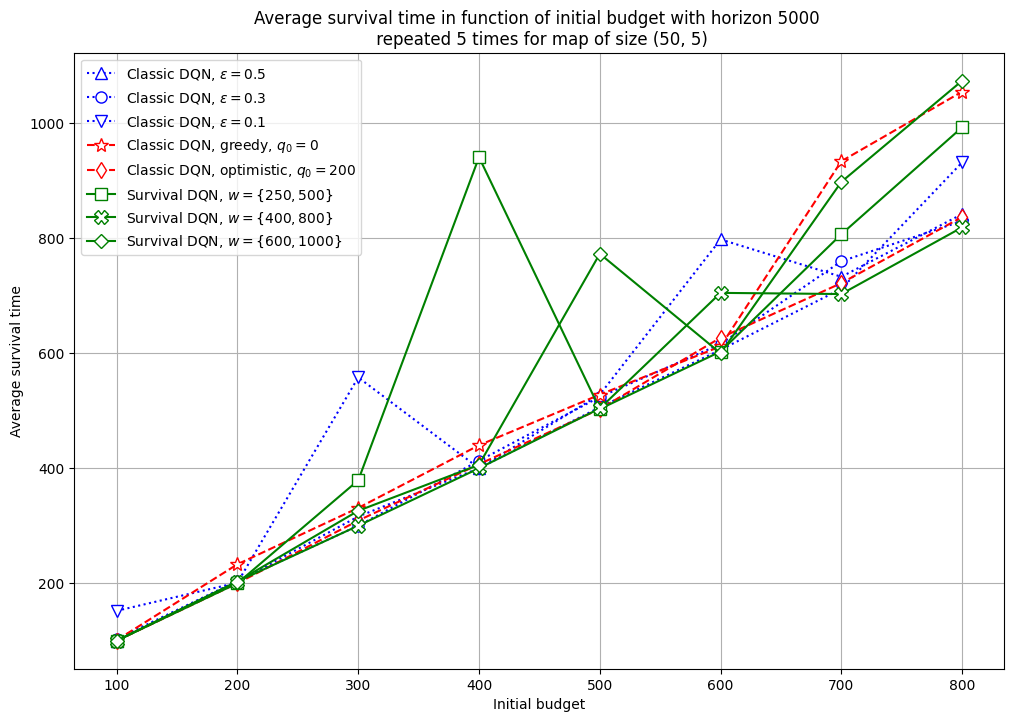

In [ ]:
fig = plt.figure(figsize=(12, 8))
plt.plot(budgets, dqn_5_time_mean, label=f"Classic DQN, $\\varepsilon=0.5$", color='b', marker='^', markerfacecolor='w', markersize=8, ls=':')
plt.plot(budgets, dqn_3_time_mean, label=f"Classic DQN, $\\varepsilon=0.3$", color='b', marker='o', markerfacecolor='w', markersize=8, ls=':')
plt.plot(budgets, dqn_1_time_mean, label=f"Classic DQN, $\\varepsilon=0.1$", color='b', marker='v', markerfacecolor='w', markersize=8, ls=':')
plt.plot(budgets, dqn_0_time_mean, label=f"Classic DQN, greedy, $q_0=0$", color='r', ls='--', marker='*', markerfacecolor='w', markersize=10)
plt.plot(budgets, dqn_h_time_mean, label=f"Classic DQN, optimistic, $q_0=200$", color='r', ls='--', marker='d', markerfacecolor='w', markersize=8)
plt.plot(budgets, dqn_survival_250_time_mean, label="Survival DQN, $w = \\{250, 500\\}$", color='g', ls='-', marker='s', markerfacecolor='w', markersize=8)
plt.plot(budgets, dqn_survival_400_time_mean, label="Survival DQN, $w = \\{400, 800\\}$", color='g', ls='-', marker='X', markerfacecolor='w', markersize=10)
plt.plot(budgets, dqn_survival_600_time_mean, label="Survival DQN, $w = \\{600, 1000\\}$", color='g', ls='-', marker='D', markerfacecolor='w', markersize=7)
plt.xlabel("Initial budget")
plt.ylabel("Average survival time")
plt.legend()
plt.grid()
plt.title(f"Average survival time in function of initial budget with horizon {horizon} \n repeated {repeat} times for map of size {map_size}")  #and survival threshold [{survival_threshold}-{exploration_threshold}] 
plt.show()

### Alive rate

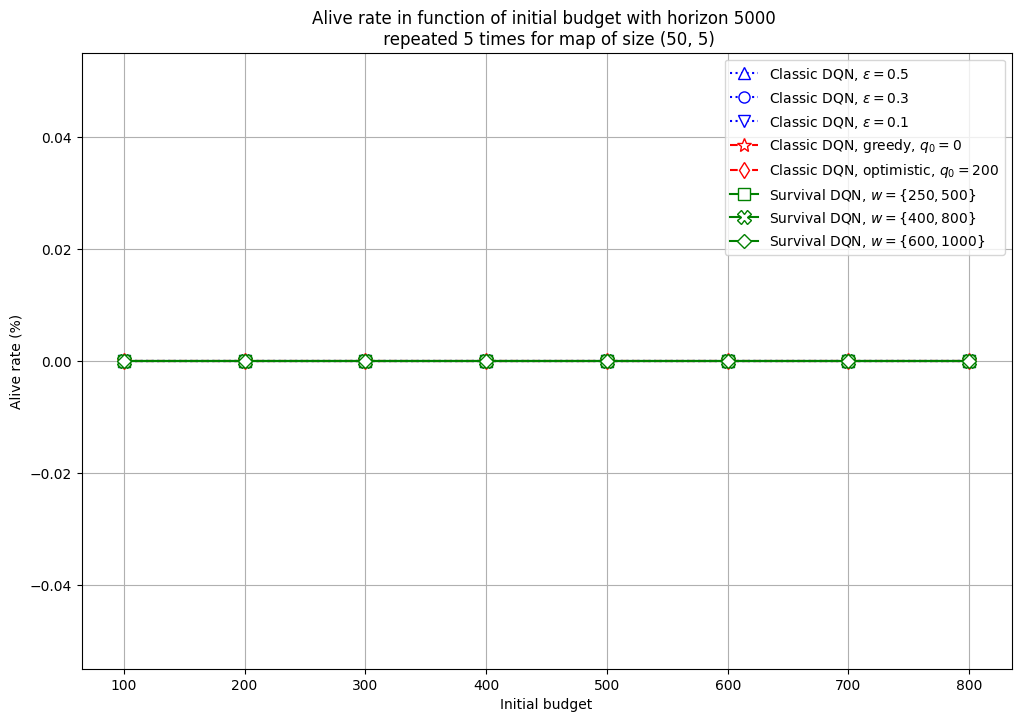

In [ ]:
fig = plt.figure(figsize=(12, 8))
plt.plot(budgets, dqn_5_alive_rate, label=f"Classic DQN, $\\varepsilon=0.5$", color='b', marker='^', markerfacecolor='w', markersize=8, ls=':')
plt.plot(budgets, dqn_3_alive_rate, label=f"Classic DQN, $\\varepsilon=0.3$", color='b', marker='o', markerfacecolor='w', markersize=8, ls=':')
plt.plot(budgets, dqn_1_alive_rate, label=f"Classic DQN, $\\varepsilon=0.1$", color='b', marker='v', markerfacecolor='w', markersize=8, ls=':')
plt.plot(budgets, dqn_0_alive_rate, label=f"Classic DQN, greedy, $q_0=0$", color='r', ls='--', marker='*', markerfacecolor='w', markersize=10)
plt.plot(budgets, dqn_h_alive_rate, label=f"Classic DQN, optimistic, $q_0=200$", color='r', ls='--', marker='d', markerfacecolor='w', markersize=8)
plt.plot(budgets, dqn_survival_250_alive_rate, label="Survival DQN, $w = \\{250, 500\\}$", color='g', ls='-', marker='s', markerfacecolor='w', markersize=8)
plt.plot(budgets, dqn_survival_400_alive_rate, label="Survival DQN, $w = \\{400, 800\\}$", color='g', ls='-', marker='X', markerfacecolor='w', markersize=10)
plt.plot(budgets, dqn_survival_600_alive_rate, label="Survival DQN, $w = \\{600, 1000\\}$", color='g', ls='-', marker='D', markerfacecolor='w', markersize=7)
plt.xlabel("Initial budget")
plt.ylabel("Alive rate (%)")
plt.legend()
plt.grid()
plt.title(f"Alive rate in function of initial budget with horizon {horizon} \n repeated {repeat} times for map of size {map_size}")
plt.show()

### Exploration rate

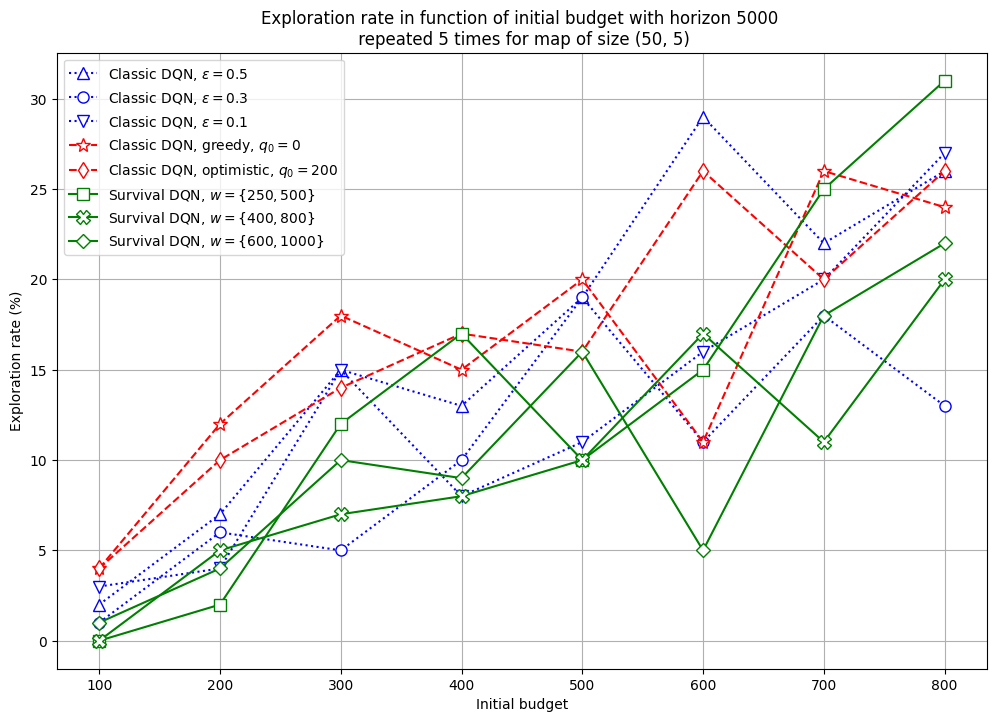

In [ ]:
fig = plt.figure(figsize=(12, 8))
#plt.plot(budgets, cde_exploration_rate, label="CDELearning")
plt.plot(budgets, dqn_5_exploration_rate, label=f"Classic DQN, $\\varepsilon=0.5$", color='b', marker='^', markerfacecolor='w', markersize=8, ls=':')
plt.plot(budgets, dqn_3_exploration_rate, label=f"Classic DQN, $\\varepsilon=0.3$", color='b', marker='o', markerfacecolor='w', markersize=8, ls=':')
plt.plot(budgets, dqn_1_exploration_rate, label=f"Classic DQN, $\\varepsilon=0.1$", color='b', marker='v', markerfacecolor='w', markersize=8, ls=':')
plt.plot(budgets, dqn_0_exploration_rate, label=f"Classic DQN, greedy, $q_0=0$", color='r', ls='--', marker='*', markerfacecolor='w', markersize=10)
plt.plot(budgets, dqn_h_exploration_rate, label=f"Classic DQN, optimistic, $q_0=200$", color='r', ls='--', marker='d', markerfacecolor='w', markersize=8)
plt.plot(budgets, dqn_survival_250_exploration_rate, label="Survival DQN, $w = \\{250, 500\\}$", color='g', ls='-', marker='s', markerfacecolor='w', markersize=8)
plt.plot(budgets, dqn_survival_400_exploration_rate, label="Survival DQN, $w = \\{400, 800\\}$", color='g', ls='-', marker='X', markerfacecolor='w', markersize=10)
plt.plot(budgets, dqn_survival_600_exploration_rate, label="Survival DQN, $w = \\{600, 1000\\}$", color='g', ls='-', marker='D', markerfacecolor='w', markersize=7)
plt.xlabel("Initial budget")
plt.ylabel("Exploration rate (%)")
plt.legend()
plt.grid()
plt.title(f"Exploration rate in function of initial budget with horizon {horizon} \n repeated {repeat} times for map of size {map_size}")
plt.show()

### Budget evolution

In [ ]:
print("Available budgets :")
print(budgets)

#plt.rcParams["figure.figsize"] = (10,10)

with_bounds = False

show_only = [300, 400, 500]
colors = ['r', 'g', 'b']


Available budgets :
[100 200 300 400 500 600 700 800]


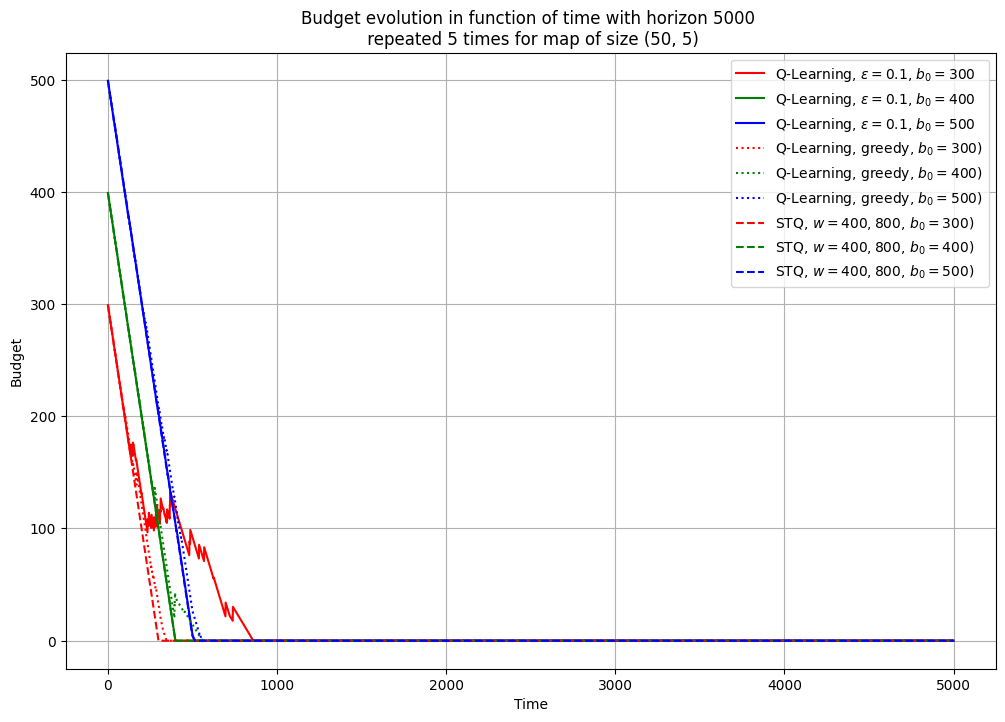

In [ ]:
t = np.arange(horizon)

fig = plt.figure(figsize=(12, 8))

n=0
for i, evo in enumerate(dqn_1_budget_evolutions_mean):
    if len(show_only) == 0 or budgets[i] in show_only:
        lines = plt.plot(t, evo, label=f"Q-Learning, $\\varepsilon=0.1$, $b_0=${budgets[i]}", ls='-', color=colors[n])
        n += 1
        if with_bounds:
            plt.fill_between(t, dqn_1_budget_evolutions_min[i], dqn_1__budget_evolutions_max[i], color=lines[0].get_color(), alpha=0.15)

n=0
for i, evo in enumerate(dqn_0_budget_evolutions_mean):
    if len(show_only) == 0 or budgets[i] in show_only:
        lines = plt.plot(t, evo, label=f"Q-Learning, greedy, $b_0=${budgets[i]})", ls=':', color=colors[n])
        n += 1
        if with_bounds:
            plt.fill_between(t, dqn_0_budget_evolutions_min[i], dqn_0_budget_evolutions_max[i], color=lines[0].get_color(), alpha=0.15)
            
n=0
for i, evo in enumerate(dqn_survival_400_budget_evolutions_mean):
    if len(show_only) == 0 or budgets[i] in show_only:
        lines = plt.plot(t, evo, label=f"STQ, $w={{400, 800}}$, $b_0=${budgets[i]})", ls='--', color=colors[n])
        n += 1
        if with_bounds:
            plt.fill_between(t, dqn_survival_400_budget_evolutions_min[i], dqn_survival_400_budget_evolutions_max[i], color=lines[0].get_color(), alpha=0.15)

#plt.yscale('symlog')

#plt.plot(t, np.full((horizon,), survival_threshold), color="magenta", label=f"Survival threshold {survival_threshold}", ls="-.")
#plt.plot(t, 4.5 * t, color="lawngreen", ls="--", label=f"Budget optimal minor")
#plt.plot(t, 49.5 * t, color="turquoise", ls="--", label=f"Budget optimal major")
plt.xlabel("Time")
plt.ylabel("Budget")
plt.legend()
plt.grid()
plt.title(f"Budget evolution in function of time with horizon {horizon} \n repeated {repeat} times for map of size {map_size}")
plt.show()